In [67]:
import pandas as pd
from typing import Generic, Optional, TypeVar
from abc import ABC, abstractmethod

class TimeSeriesModel(ABC):
    """ DBVO time Series model

    This is the parent class for all DBVO time series models
    
    Attributes:
        data: pandas dataframe with two columns ["time", "value"]
        params: model parameters
        split_n: for train/test split purposes - specifies the number of training samples
    
    Returns:
        pred_df: pandas dataframe with three columns ["time", "pred", "pred_lower", "pred_upper"]
        
    
    """
    def __init__(self,
                 data: Optional[pd.DataFrame],
                 params: Optional[dict],
                 split_n: Optional[int] = None, 
                 time_col_name:str = 'time',
                 val_col_name:str = 'value'
                  ):
        self.data = data
        self.params = params
        self.__type__ = "dvbo_time_series_model"
        self.time_col_name = time_col_name
        self.val_col_name = val_col_name
        
        if data is not None:
            self.validate_column_names()
            
        if split_n is not None:
            self.split_n = split_n
            self.train, self.test = self.split(
                self.data_prep(data),
                self.split_n
            )   
            
        
    def validate_column_names(self) -> None:
        """
        Validates input data frame columns ['time', 'value']
        """ 
        if self.time_col_name not in self.data.columns or self.val_col_name not in self.data.columns:
            raise ValueError("columns need to be named ['time', 'value']")
                
    def split(self, data, n):
        return data[:-n], data[-n:]
        
    @abstractmethod
    def fit(self, train, test=None):
        pass

    @abstractmethod
    def predict(self, steps):
        pass

    @abstractmethod
    def data_prep(self, data):
        pass

    @abstractmethod
    def plot(self):
        pass


In [68]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
from kats.consts import TimeSeriesData
from kats.models.sarima import SARIMAModel, SARIMAParams
from kats.models.prophet import ProphetModel, ProphetParams
from kats.models.holtwinters import HoltWintersParams, HoltWintersModel
from kats.models.ensemble.ensemble import EnsembleParams, BaseModelParams
from kats.models.ensemble.kats_ensemble import KatsEnsemble
from kats.models import (
    arima,
    holtwinters,
    linear_model,
    prophet, 
    quadratic_model,
    sarima,
    theta,
)

warnings.simplefilter(action='ignore')
#sys.path.append("../")

### Load data

In [69]:
try:
    air_passengers_df = pd.read_csv("../kats/data/air_passengers.csv")
except FileNotFoundError: 
    air_passengers_df = pd.read_csv("air_passengers.csv")
# rename columns
temp1 = list(air_passengers_df.columns)
air_passengers_df.columns = ["time", "value"]
temp2 = list(air_passengers_df.columns)
print(f"renaming columns {temp1} to {temp2}")
print(air_passengers_df.shape)

#create Kats time Series object
air_passengers_ts = TimeSeriesData(air_passengers_df)

#quick data check
df = air_passengers_df
min_time = min(df.time)
max_time = max(df.time)
print(min_time)
print(max_time)
df.head()

renaming columns ['ds', 'y'] to ['time', 'value']
(144, 2)
1949-01-01
1960-12-01


,time,value
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


## 1.1 SARIMA

Fit SARIMA model by maximum likelihood via Kalman filter.

In [86]:
class KatsSarimaModel(TimeSeriesModel):
    def __init__(self,
                 data: pd.DataFrame,
                 params: Optional[dict]
                ):         
        
        #create Kats time Series object
        self.data_ts = TimeSeriesData(air_passengers_df)
        
        #create Kats params object
        
        #params_list = [k + "=" + str(v) for k,v in params.items()]
        #print(f"params_list = {params_list}")
        self.params_sarima = SARIMAParams(**params)
        
        #TODO. Decide if we really need to defind type hints in base model?
        super().__init__(data, params)
        
    def fit(self):
        print(self.params_sarima)
        # define model
        self.m_sarima = SARIMAModel(data=self.data_ts, params=self.params_sarima)
        # fit SARIMA model
        self.m_sarima.fit()     
        
    def predict(self, steps):
        self.pred_sarima = self.m_sarima.predict(
            steps=steps, 
            freq="MS"
        )
        return self.pred_sarima
    
    def plot(self):
        # make plot to visualize
        self.m_sarima.plot()
    
    def data_prep(self):
        pass

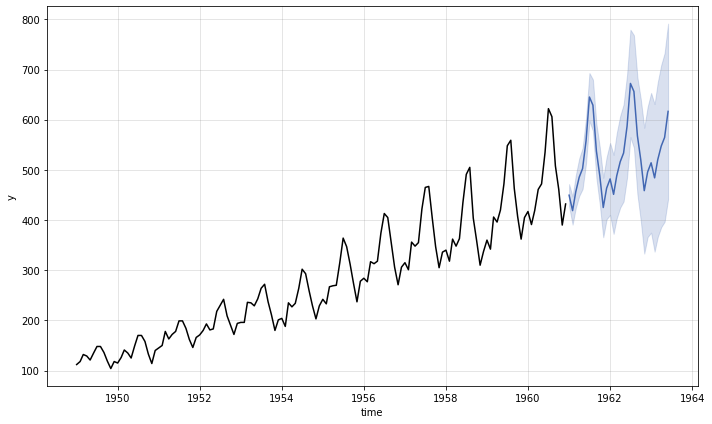

In [91]:
params = {'p': 2, 
          'd': 1, 
          'q': 1, 
          'trend' : 'ct', 
          'seasonal_order':(1,0,1,12)
         }

m_sarima = KatsSarimaModel(air_passengers_df, params)
m_sarima.fit()
pred_sarima = m_sarima.predict(30)
m_sarima.plot()

In [92]:
pred_sarima.head()

,time,fcst,fcst_lower,fcst_upper
144,1961-01-01,449.517740,427.478097,471.557382
145,1961-02-01,418.756222,390.889634,446.622811
146,1961-03-01,455.877392,423.419947,488.334837
147,1961-04-01,485.351055,447.940548,522.761561
148,1961-05-01,502.589071,461.764247,543.413894
